### Note: cv2.imshow does not work with collab, if required use the following:
from google.colab.patches import cv2_imshow \n
cv2_imshow(img)

In [ ]:
import cupyx.scipy.ndimage as cupy_filters

from numba import int64
import numba
from numba import cuda
import cupy as cp
import numpy as np
import time

In [ ]:
CLIP = lambda x: np.uint8(max(0, min(x, 255)))
AtmosphericLight_Y = 0
AtmosphericLight = np.zeros(3)

## 30 FPS @ img size (300 x 400)[h,w]
@cuda.jit
def box_filter_kernel(input_arr, output_arr, width, height, radius):
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    bw = cuda.blockDim.x
    bh = cuda.blockDim.y
    gw = cuda.gridDim.x
    gh = cuda.gridDim.y

    x, y = tx + bw * cuda.blockIdx.x, ty + bh * cuda.blockIdx.y

    if x < width and y < height:
        pixel_sum = 0.0
        num_pixels = 0

        for i in range(-radius, radius + 1):
            for j in range(-radius, radius + 1):
                xx = x + i
                yy = y + j

                if xx >= 0 and xx < width and yy >= 0 and yy < height:
                    pixel_sum += input_arr[yy, xx]
                    num_pixels += 1

        output_arr[y, x] = pixel_sum / num_pixels


@cuda.jit(device=True)
def cached_trans(imgY_val, AtmosphericLight_Y, fTrans):
    return (imgY_val - AtmosphericLight_Y) / fTrans + AtmosphericLight_Y


class Dehazer:
    def __init__(self, img_input):
        self.img_input = img_input
        self.imgY = cv2.cvtColor(img_input, cv2.COLOR_BGR2YCR_CB)[:,:,0]
        self.imgY_gpu = cp.asarray(self.imgY)
        self.AtmosphericLight_Y_gpu = cp.asarray(AtmosphericLight_Y)
        self.AtmosphericLight = AtmosphericLight
        self.AtmosphericLight_Y = AtmosphericLight_Y
        self.width = self.img_input.shape[1]
        self.height = self.img_input.shape[0]
        self.pfTransmission = np.zeros(img_input.shape[:2])

    def AirLightEstimation(self, origin, height, width):
        UpperLeft  = self.img_input[origin[0]:origin[0]+int(round(height/2)), origin[1]:origin[1]+int(round(width/2))]
        UpperRight = self.img_input[origin[0]:origin[0]+int(round(height/2)), origin[1]+int(round(width/2)):origin[1]+width]
        LowerLeft  = self.img_input[origin[0]+int(round(height/2)):origin[0]+height, origin[1]:origin[1]+int(round(width/2))]
        LowerRight = self.img_input[origin[0]+int(round(height/2)):origin[0]+height, origin[1]+int(round(width/2)):origin[1]+width]

        if height*width > 200:
            maxVal = 0
            idx = -1
            for i, blk in enumerate([UpperLeft, UpperRight, LowerLeft, LowerRight]):
                D = np.mean(blk) - np.std(blk)
                if D > maxVal:
                    maxVal = D
                    idx = i
            self.AirLightEstimation(( origin[0]+int(idx/2)*int(round(height/2)),
                                      origin[1]+int(idx%2)*int(round(width/2))),
                                      int(round(height/2)), int(round(width/2)))
        else:
            global AtmosphericLight, AtmosphericLight_Y
            minDist = 1e10
            for i in range(height):
                for j in range(width):
                    Dist = np.linalg.norm(self.img_input[origin[0]+i,origin[1]+j,:] - np.array([255,255,255]))
                    if Dist < minDist:
                        minDist = Dist
                        self.AtmosphericLight = self.img_input[origin[0]+i, origin[1]+j,:]
                        ## RGB -> Y
                        self.AtmosphericLight_Y = int((self.AtmosphericLight[2]*0.299 + self.AtmosphericLight[1]*0.587 + self.AtmosphericLight[0]*0.114))
                        AtmosphericLight = self.AtmosphericLight
                        AtmosphericLight_Y = self.AtmosphericLight_Y

            ## renew airlight when abrupt change
            if abs(self.AtmosphericLight_Y - AtmosphericLight_Y) > 50:
                AtmosphericLight_Y = self.AtmosphericLight_Y
                AtmosphericLight = self.AtmosphericLight


    def GaussianTransmissionRefine(self):
            r = 29  # radius of the Gaussian filter

            # Apply Gaussian filtering to the transmission map
            t = cv2.GaussianBlur(self.pfTransmission, (r, r), 0)
            # t = np.round(t,1)
            # t= np.ceil(t * 10) / 10
            self.pfTransmission = t


    @staticmethod
    @cuda.jit
    def calculate_average_kernel(imgY, average, blk_size, height, width):

        i, j = cuda.grid(2)
        bx, by = cuda.blockIdx.x, cuda.blockIdx.y
        tx, ty = cuda.threadIdx.x, cuda.threadIdx.y
        tile_width, tile_height = 8,8

        shared = cuda.shared.array(shape=(tile_height, tile_width), dtype='int64')

        for di in range(blk_size):
            for dj in range(blk_size):
                ii = i + di
                jj = j + dj
                if ii < height and jj < width:
                    shared[ty, tx] = imgY[ii, jj]

            cuda.syncthreads()

            sum_val = 0
            count = 0
            for dy in range(tile_height):
                for dx in range(tile_width):
                    ii = bx * tile_height + dy
                    jj = by * tile_width + dx
                    if ii < height and jj < width:
                        sum_val += shared[dy, dx]
                        count += 1
            average[i, j] = sum_val / count

    @staticmethod
    @cuda.jit
    def calculate_econtrast_kernel(imgY, average, fTrans, Econtrast, over255, lower0, AtmosphericLight_Y, blk_size, height, width):
        i, j = cuda.grid(2)
        bx, by = cuda.blockIdx.x, cuda.blockIdx.y
        tx, ty = cuda.threadIdx.x, cuda.threadIdx.y
        tile_width, tile_height = 8,8

        shared = cuda.shared.array(shape=(tile_height, tile_width), dtype='uint8')
        avg_shared = cuda.shared.array(shape=(tile_height,tile_width),dtype='uint8')

        for di in range(blk_size):
            for dj in range(blk_size):
                ii = i+di
                jj = j + dj
                if ii < height and jj < width:
                    shared[ty,tx] = imgY[ii,jj]
                    avg_shared[ty,tx] = average[ii,jj]

        cuda.syncthreads()

        # Calculate Econtrast, over255, and lower0 values for the tile
        if i < height and j < width:
            transed = cached_trans(shared[ty,tx], AtmosphericLight_Y, fTrans)
            diff = transed - avg_shared[ty,tx]
            Econtrast[i, j] = -diff ** 2 / blk_size ** 2
            over255[i, j] = ((transed > 255) * (transed - 255) ** 2)
            lower0[i, j] = ((transed < 0) * (transed) ** 2)



    @staticmethod
    @cuda.jit
    def update_min_e_kernel(Econtrast, over255, lower0, MinE, fOptTrs, lamdaL, height, width, fTrans):
        i, j = cuda.grid(2)
        if i < height and j < width:
            E = Econtrast[i, j] + lamdaL * (over255[i, j] + lower0[i, j])
            if E < MinE[i, j]:
                MinE[i, j] = E
                fOptTrs[i, j] = fTrans



    def TransmissionEstimation(self, blk_size):
        maxx = (self.height // blk_size) * blk_size
        maxy = (self.width // blk_size) * blk_size
        lamdaL = 4
        MinE_gpu = cp.full(self.imgY.shape, 1e10)
        fOptTrs_gpu = cp.zeros(self.imgY.shape)
        average_gpu = cp.zeros(self.imgY.shape)
        threads_per_block = (min(blk_size, self.height), min(blk_size, self.width))
        blocks_per_grid = ((maxx + threads_per_block[0]-1) // threads_per_block[0],
                          (maxy + threads_per_block[1]-1) // threads_per_block[1])
        self.calculate_average_kernel[blocks_per_grid, threads_per_block](self.imgY_gpu, average_gpu, blk_size, self.height, self.width)
        for t, fTrans in enumerate(np.linspace(0.3, 1, 8)):
            Econtrast_gpu = cp.zeros(self.imgY.shape)
            over255_gpu = cp.zeros(self.imgY.shape)
            lower0_gpu = cp.zeros(self.imgY.shape)
            #(imgY, average, fTrans, Econtrast, over255, lower0, AtmosphericLight_Y, blk_size, height, width)
            # (imgY, average, fTrans, Econtrast, over255, lower0, AtmosphericLight_Y, height, width):
            self.calculate_econtrast_kernel[blocks_per_grid, threads_per_block](self.imgY_gpu, average_gpu.astype('uint8'), fTrans, Econtrast_gpu, over255_gpu, lower0_gpu, self.AtmosphericLight_Y,blk_size, self.height, self.width)
            self.update_min_e_kernel[blocks_per_grid, threads_per_block](Econtrast_gpu, over255_gpu, lower0_gpu, MinE_gpu, fOptTrs_gpu, lamdaL, self.height, self.width, fTrans)
        self.pfTransmission = cp.asnumpy(fOptTrs_gpu)



    def box_filter(self,arr, radius):
      width, height = arr.shape
      output_arr = cp.zeros((height, width), dtype='float32')

      threads_per_block = (16, 16)
      blocks_per_grid_x = int(np.ceil(width / threads_per_block[0]))
      blocks_per_grid_y = int(np.ceil(height / threads_per_block[1]))
      blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

      box_filter_kernel[blocks_per_grid, threads_per_block](arr, output_arr, width, height, radius)

      return output_arr

    def GuidedFilter_GPU(self, rads, eps):
        self.pfTransmission_gpu = cp.asarray(self.pfTransmission)
        meanI = cupy_filters.uniform_filter(self.imgY_gpu / 255, size=(rads, rads), mode='reflect')
        meanP = cupy_filters.uniform_filter(self.pfTransmission_gpu, size=(rads, rads), mode='reflect')
        meanIP = cupy_filters.uniform_filter(self.imgY_gpu / 255 * self.pfTransmission_gpu, size=(rads, rads), mode='reflect')
        covIP = meanIP - meanI * meanP
        meanII = cupy_filters.uniform_filter((self.imgY_gpu / 255) ** 2, size=(rads, rads), mode='reflect')
        varI = meanII - meanI ** 2
        a = covIP / (varI + eps)
        b = meanP - a * meanI
        meanA = cupy_filters.uniform_filter(a, size=(rads, rads), mode='reflect')
        meanB = cupy_filters.uniform_filter(b, size=(rads, rads), mode='reflect')
        res = meanA * self.imgY_gpu / 255 + meanB
        self.pfTransmission_gpu = cp.maximum(res, cp.full((self.height, self.width), 0.6))


    def GuidedFilter_CPU(self, rads, eps):
      ## Gudance image is ImgY , input image is pfTransmission
        meanI = cv2.boxFilter(self.imgY/255, -1, (rads,rads), borderType=cv2.BORDER_REPLICATE)
        meanP = cv2.boxFilter(self.pfTransmission, -1, (rads,rads), borderType=cv2.BORDER_REPLICATE)
        meanIP = cv2.boxFilter(self.imgY/255*self.pfTransmission, -1, (rads,rads), borderType=cv2.BORDER_REPLICATE)
        covIP = meanIP - meanI * meanP
        meanII = cv2.boxFilter((self.imgY/255)**2, -1, (rads,rads), borderType=cv2.BORDER_REPLICATE)
        varI = meanII - meanI ** 2
        a = covIP / (varI + eps)
        b = meanP - a * meanI
        meanA = cv2.boxFilter(a, -1, (rads,rads), borderType=cv2.BORDER_REPLICATE)
        meanB = cv2.boxFilter(b, -1, (rads,rads), borderType=cv2.BORDER_REPLICATE)
        res = meanA * self.imgY/255 + meanB
        self.pfTransmission = res
        self.pfTransmission = np.maximum(self.pfTransmission, np.full((self.height, self.width), 0.6))

    def RestoreImage(self):
        img_out = np.zeros(self.img_input.shape)
        self.pfTransmission = np.maximum(self.pfTransmission, np.full((self.height, self.width), 0.6))
        for i in range(3):
            img_out[:,:,i] = np.clip(((self.img_input[:,:,i].astype(int) - AtmosphericLight[i]) / self.pfTransmission + AtmosphericLight[i]),0,255)

        return img_out


Single Image

In [ ]:
def downscale_frame(dhz_img):
    scale_factor = 0.3
    #TODO dynamically scale image based on size : hardcoded to 300*400
    #OG img dim
    height, width = dhz_img.shape[:2]

    #new dim
    new_height = int(height * scale_factor)
    new_width = int(width * scale_factor)
    # Downscale
    downscaled_img = cv2.resize(dhz_img, (400,300), interpolation=cv2.INTER_LINEAR)
    dhz_img = downscaled_img
    return dhz_img


In [ ]:
import time

In [ ]:
def dehaze_img(img):
  dhz_img = downscale_frame(img)
  dhz = Dehazer(dhz_img)
  dhz.AirLightEstimation((0,0),dhz_img.shape[0],dhz_img.shape[1])
  blk_size = 8
  dhz.TransmissionEstimation(blk_size)

  dhz.GaussianTransmissionRefine()
  eps = 0.001
  dhz.GuidedFilter_GPU(20,eps)
  im = dhz.RestoreImage().astype('uint8')
  return im

In [ ]:
import cv2

In [ ]:
def dehaze_video(video_url):
    video_capture = cv2.VideoCapture(video_url)
    ret, init = video_capture.read()
    h, w = init.shape[0], init.shape[1]
    fps = video_capture.get(cv2.CAP_PROP_FPS)
    print("fps:", fps, ", width:", w, ", height:", h)
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter("./output_video.mp4", fourcc, fps, (w, h))
    cnt = 0
    while True:
        ret, frame = video_capture.read()
        frame =downscale_frame(frame)
        # cv2.namedWindow('input_img', cv2.WINDOW_NORMAL)
        # cv2.imshow('input_img', frame)
        if ret == True and cnt % 2 == 0:                   # process every 2 frames -> avoid lag
            dhz = Dehazer(frame)
            if cnt==0:                                   # use the airlight of the first frame
                dhz.AirLightEstimation((0,0), frame.shape[0], frame.shape[1])
            blk_size = 8
            dhz.TransmissionEstimation(blk_size)
            dhz.GaussianTransmissionRefine()
            eps = 0.001
            dhz.GuidedFilter_GPU(20,eps)
            im = dhz.RestoreImage().astype('uint8')
            cv2.namedWindow('result_img', cv2.WINDOW_NORMAL)
            cv2.imshow('result_img', im)
            out.write(im)
    #         #print(cnt)
        elif ret != True:
            video_capture.release()
            out.release()
            cv2.destroyAllWindows()
            break
        cnt += 1

        if cv2.waitKey(1) & 0xFF == ord('q'):   break

In [ ]:
# diff = np.power(curr[:][0] - prev , 2)

# w = np.mean(np.exp(-1*diff/100))

# [][]

# prev_t = dhz.pTransmission
# w >= 0.85
# updated_t = guided_filter(prev_t, curr,eps, r)
# max(0.05, updated_t)
# A = 0

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
im1 = cv2.imread('./58.png')
im2 = cv2.imread('./70.png')
im3 = cv2.imread('./77.png')


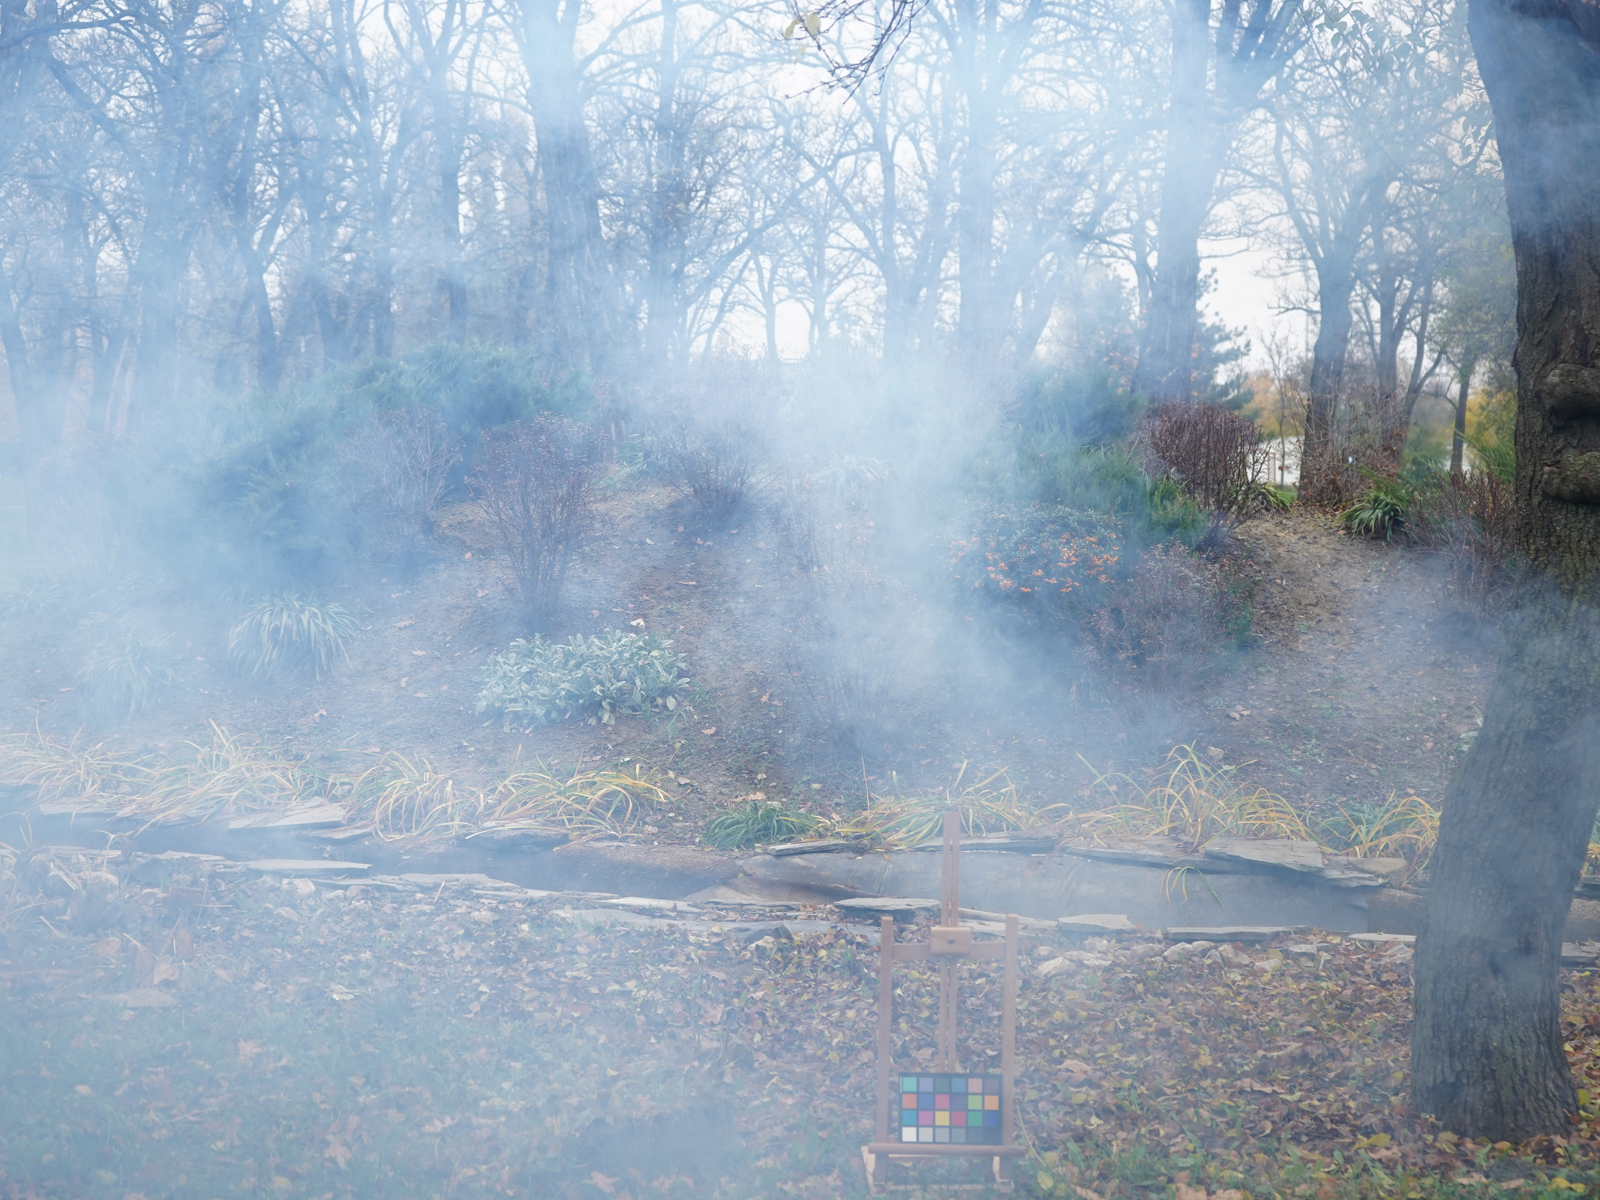

In [ ]:
%%time
img1 = dehaze_img(im1)

CPU times: user 33.7 ms, sys: 956 µs, total: 34.7 ms
Wall time: 34.8 ms


In [ ]:
%%time
img2 = dehaze_img(im2)

CPU times: user 35.2 ms, sys: 838 µs, total: 36 ms
Wall time: 35.7 ms


In [ ]:
%%time
img3 = dehaze_img(im3)

CPU times: user 34.4 ms, sys: 1.67 ms, total: 36.1 ms
Wall time: 34.8 ms


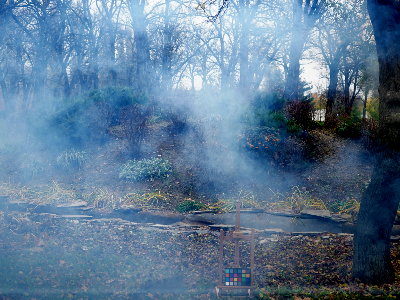

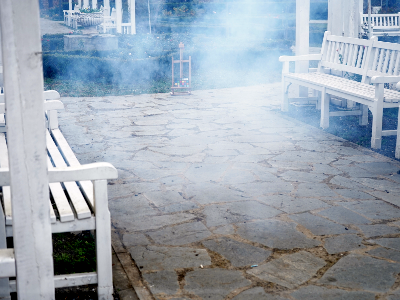

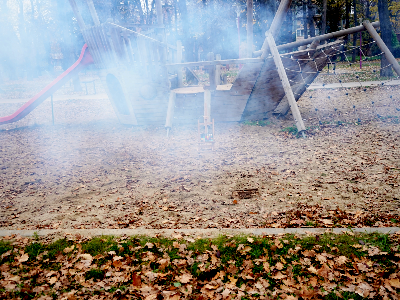

In [ ]:
cv2_imshow(img1)
cv2_imshow(img2)
cv2_imshow(img3)

In [ ]:
# %%time
# start = time.time()
# dhz_img = img
# print(f"Downscaling takes {(time.time()-start)*1000}ms")
# start = time.time()
# dhz = Dehazer(dhz_img)
# print(f"init takes {(time.time()-start)*1000}ms")
# start = time.time()
# dhz.AirLightEstimation((0,0),dhz_img.shape[0],dhz_img.shape[1])
# print(f"AE takes {(time.time()-start)*1000}ms")
# # print(dhz.AtmosphericLight_Y)
# blk_size = 8
# start = time.time()
# dhz.TransmissionEstimation(blk_size)
# # print(dhz.pfTransmission)
# dhz.GaussianTransmissionRefine()
# print(f"TF takes {(time.time()-start)*1000}ms")
# eps = 0.001
# start = time.time()
# dhz.GuidedFilter_GPU(20,eps)
# print(f"GF takes {(time.time()-start)*1000}ms")
# start = time.time()
# im = dhz.RestoreImage().astype('uint8')
# print(f"restoring takes {(time.time()-start)*1000}ms")

Downscaling takes 0.001430511474609375ms
init takes 18.755674362182617ms
AE takes 91.89224243164062ms
TF takes 344.15626525878906ms
GF takes 83.24408531188965ms
restoring takes 142.87614822387695ms
CPU times: user 226 ms, sys: 73.4 ms, total: 299 ms
Wall time: 698 ms


In [ ]:
im.shape

(300, 400, 3)

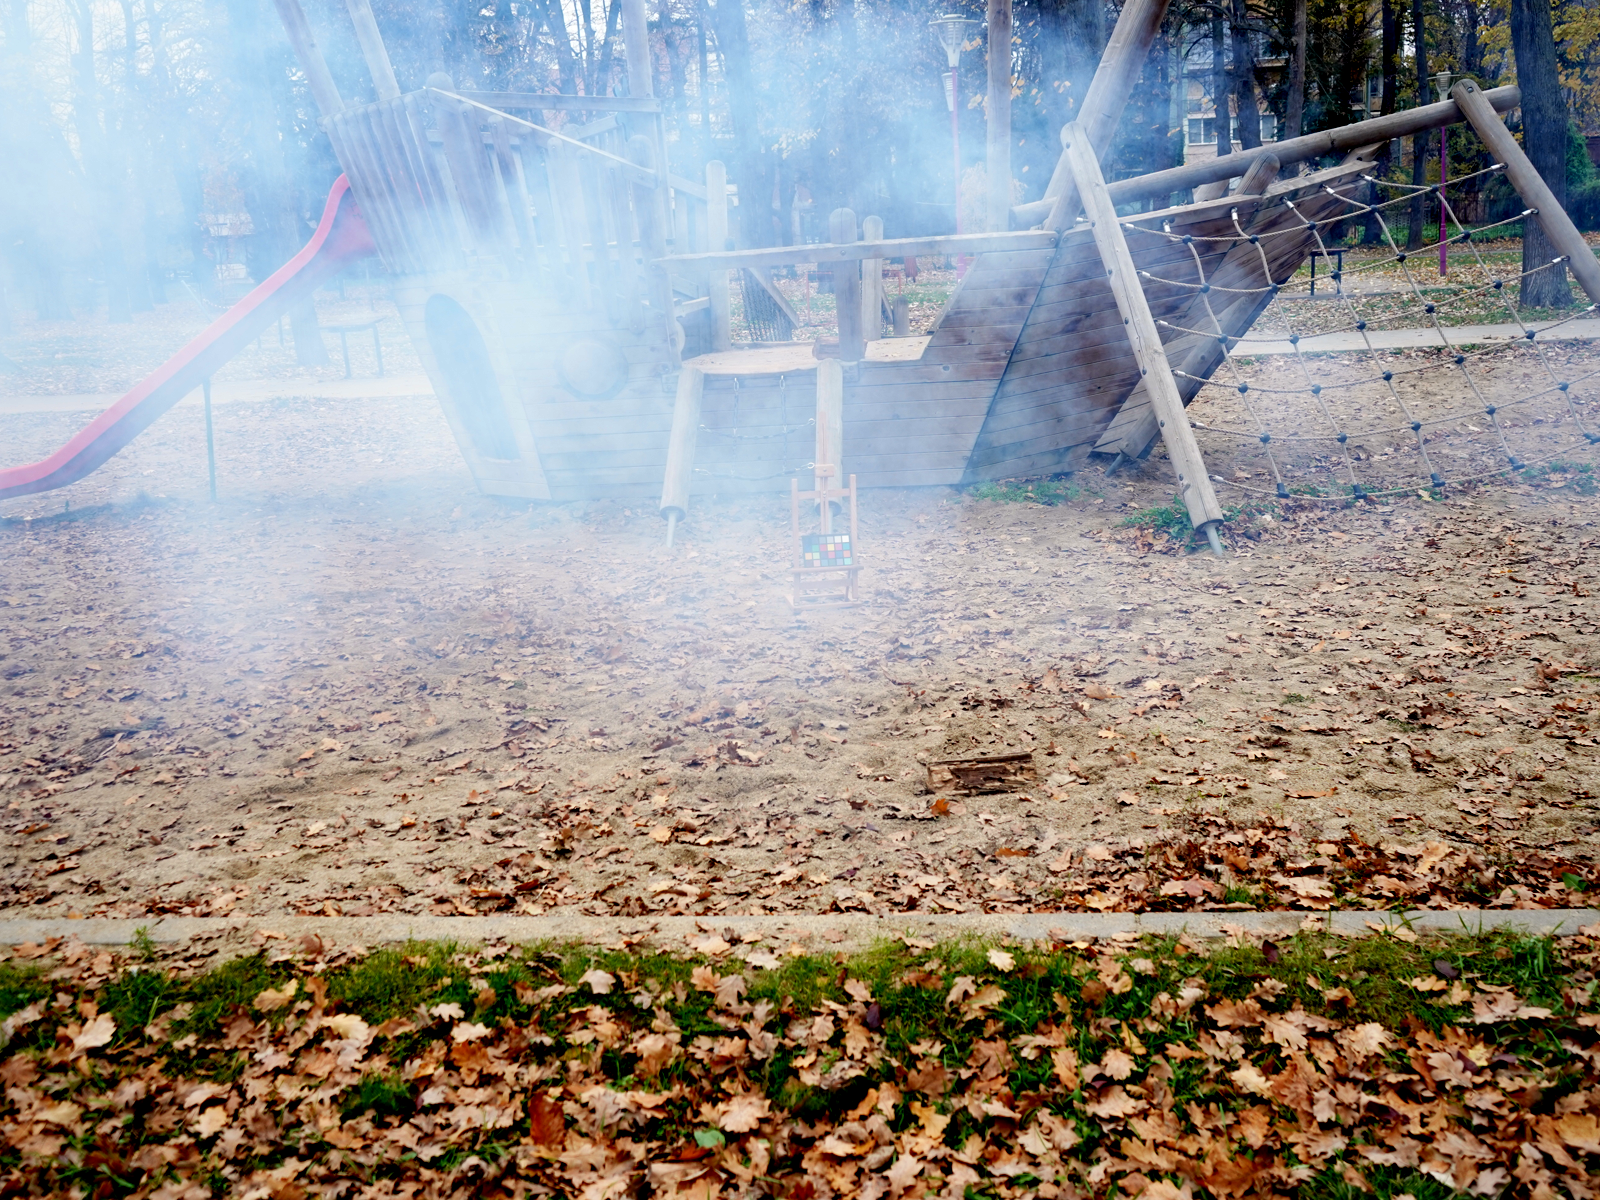

In [ ]:
cv2_imshow(im)

In [ ]:
cv2_imshow(img)

In [ ]:
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)


def adjust_saturation(image, saturation_factor=1.0):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    h, s, v = cv2.split(hsv)

    s = s * saturation_factor

    s = np.clip(s, 0, 255).astype(hsv.dtype)

    hsv = cv2.merge([h, s, v])

    image_adjusted = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    return image_adjusted

In [ ]:
%%time
brighter_img = adjust_gamma(im,0.8)
brighter_img = adjust_saturation(im, 0.7)


CPU times: user 4.64 ms, sys: 45 µs, total: 4.68 ms
Wall time: 10.7 ms


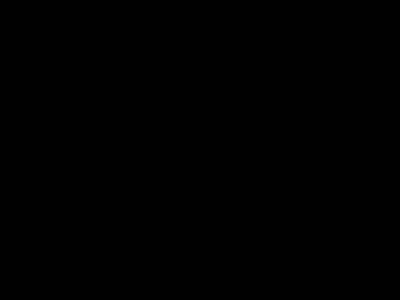

In [ ]:
cv2_imshow(brighter_img)